## Fdec Gadget

In [11]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import time_conversion as tiempo
import density
import rotation_mio as rot

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

path = '/home/ornela/SimCLUES/'
# path = '/home/omarioni/'

atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
# aexp = aexp[::-1]

# path = '/mnt/is2/alejandro/ornella/'
##hasta 50

snapshot=range(496,50,-1)
for isnap in snapshot:
    snap = h5py.File(path + 'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
#     print aexp[isnap]

#     lala

    for i in range(1,3):
        cm   = snap['subhalo_0'+ str('%s'%vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s'%vector[i])+ '/R200'].value

        pstr = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Coordinates'].value
        mstr = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Coordinates'].value
        mgas = snap['subhalo_0'+ str('%s'%vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Coordinates'].value
        mdrk = snap['subhalo_0'+ str('%s'%vector[i])+ '/Drk/Masses'].value

        z = a0/aexp[isnap] - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        time = tiempo.conv(z, h, omega_lambda, omega_matter)

    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
        ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
        zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
        ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
        zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
        ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
        zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        mstr = mstr*1e10/h
        mgas = mgas*1e10/h
        mdrk = mdrk*1e10/h
        
        r200 = r200*aexp[isnap]/h
        
#         print 'r200 =', r200
        rgal=0.15*r200
        
        limit    = np.where(rstr<rgal)
        r_sort   = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])
        
        Mgal_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mgal_str[-1]
    

    #------------------ calculamos M90------------------------------------------
        razon  = Mgal_str/M_gal
        cincuenta,    = np.where(razon < 0.50)

        r50 = r_sort[cincuenta][-1]
        M50 = Mgal_str[cincuenta][-1]

        #componentes de la velocidad del centro de masa
        veloc, = np.where(rstr < r50)

        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        #velocidades de las estrellas respecto del centro de masa de la galaxia
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        #-------------------------------------------------------------------------------------
        #hago la rotación de las coordenadas respecto del momento angular    
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        rn = np.sqrt(xn**2 + yn**2 + zn**2 )

        limit, = np.where(rn < rgal )

        R = np.sqrt(xn[limit]**2+yn[limit]**2)

        nbin = 25
        den, Rbin = density.surf_density(R,mstr[limit],nbin)
        
        
        cut, = np.where(Rbin > 3*aexp[isnap])
        pol  = np.polyfit(Rbin[cut],np.log(den[cut]),1)

        Rd = -1./pol[0]

        Md = 2*np.pi*np.exp(pol[1])*Rd**2

    #--------------------------------------------         
        rtot = np.concatenate([rstr, rgas, rdrk])
        mtot = np.concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])
        
        limit_drk   = np.where(rdrk<r200)
        rdrk_sort   = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rtot[limit_drk])
        
        Mc_drk = np.cumsum(mdrk[limit_drk][rdrk_indice])
        
#-------------------------------------------------------------- 
        Mtot_50 = Mc_tot[np.where(rtot_sort < r50)][-1]

        Vr50 = np.sqrt((G*Mtot_50)/r50)
        Vdrk = np.sqrt((G*Mc_drk)/rdrk_sort)
        
        fdisk = Vr50 / np.sqrt((G*M_gal)/r50)

        fdec = Vr50/Vdrk.max()
        
        
        path3 = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'
        archivo =  open(path3 + str('%s'%vector2[i]) + '_fdec_GD.dat','a')
        archivo.write(str('%12.6f'% time) +'\t'+
                      str('%12.6f'% fdisk) +'\t'+
                      str('%12.6f'% fdec) +'\n')
        archivo.close()


/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt
rotation_mio.py:5: RuntimeWarning: invalid value encountered in sqrt
  r   = np.sqrt(x**2+y**2+z**2)
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in sqrt
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


In [16]:
import numpy as np
# path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'
data = np.loadtxt(path + 'M31_fdec_GD.dat')
time_M31gd  = data[:,0]
fdisc_M31gd = data[:,1]
fdec_M31gd  = data[:,2]

data = np.loadtxt(path + 'MW_fdec_GD.dat')
time_MWgd  = data[:,0]
fdisc_MWgd = data[:,1]
fdec_MWgd  = data[:,2]

data = np.loadtxt(path + 'M33_fdec_GD.dat')
time_M33gd  = data[:,0]
fdisc_M33gd = data[:,1]
fdec_M33gd  = data[:,2]


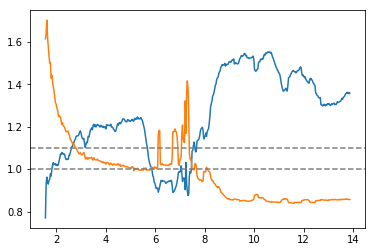

In [33]:
import matplotlib.pyplot as plt

plt.plot(time_M31gd, fdec_M31gd)
plt.plot(time_M31gd, fdisc_M31gd)
plt.axhline(y=1.1,ls='--', color='gray')
plt.axhline(y=1.,ls='--', color='gray')

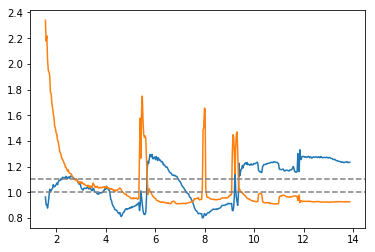

In [35]:
import matplotlib.pyplot as plt

plt.plot(time_MWgd, fdec_MWgd)
plt.plot(time_MWgd, fdisc_MWgd)
plt.axhline(y=1.1,ls='--', color='gray')
plt.axhline(y=1.,ls='--', color='gray')

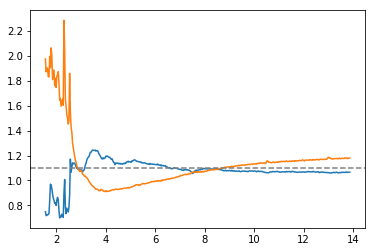

In [18]:
import matplotlib.pyplot as plt

plt.plot(time_M33gd, fdec_M33gd)
plt.plot(time_M33gd, fdisc_M33gd)
plt.axhline(y=1.1,ls='--', color='gray')

## Fdec Gasoline

In [19]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import numpy as np


G = 4.299e-6
a0=1
vector2 = ('M31','MW','M33')
vector = (1,2,4)

path = '/home/ornela/SimCLUES/'
# path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,0,-1):
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    for i in range(0,3):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'][()]
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'][()]
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'][()]
        h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'][()]
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'][()]

        pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'][()]
        mstr = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Masses'][()]
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'][()]

        pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'][()]
        mgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'][()]

        pdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Coordinates'][()]
        mdrk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'][()]


    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0]) #*aexp
        ystr = (pstr[:,1]-cm[1])
        zstr = (pstr[:,2]-cm[2])
        rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

        xgas = (pgas[:,0]-cm[0])
        ygas = (pgas[:,1]-cm[1])
        zgas = (pgas[:,2]-cm[2])
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

        xdrk = (pdrk[:,0]-cm[0])
        ydrk = (pdrk[:,1]-cm[1])
        zdrk = (pdrk[:,2]-cm[2])
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

        v_x = vel[:,0]
        v_y = vel[:,1]
        v_z = vel[:,2]

    #----------------------masas----------------------------
        r200 = r200*aexp
        rgal=0.15*r200

        limit    = np.where(rstr<rgal)
        r_sort   = np.sort(rstr[limit])
        r_indice = np.argsort(rstr[limit])
        
        Mgal_str = np.cumsum((mstr[limit])[r_indice])
        M_gal = Mgal_str[-1]
        
    #------------------ calculamos M90------------------------------------------
        razon  = Mgal_str/M_gal
        cincuenta,    = np.where(razon < 0.50)

        r50 = r_sort[cincuenta][-1]
        M50 = Mgal_str[cincuenta][-1]

        #componentes de la velocidad del centro de masa
        veloc, = np.where(rstr < r50)

        vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

        #velocidades de las estrellas respecto del centro de masa de la galaxia
        vx = v_x - vxcm
        vy = v_y - vycm
        vz = v_z - vzcm

        #-------------------------------------------------------------------------------------
        #hago la rotación de las coordenadas respecto del momento angular    
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        rn = np.sqrt(xn**2 + yn**2 + zn**2 )

        limit, = np.where(rn < rgal )

        R = np.sqrt(xn[limit]**2+yn[limit]**2)

        nbin = 25
        den, Rbin = density.surf_density(R,mstr[limit],nbin)
        
        
        cut, = np.where(Rbin > 3*aexp)
        pol  = np.polyfit(Rbin[cut],np.log(den[cut]),1)

        Rd = -1./pol[0]

        Md = 2*np.pi*np.exp(pol[1])*Rd**2
     
   #--------------------------------------------         
        rtot = np.concatenate([rstr, rgas, rdrk])
        mtot = np.concatenate([mstr, mgas, mdrk])
        
        limit_tot   = np.where(rtot<r200)
        rtot_sort   = np.sort(rtot[limit_tot])
        rtot_indice = np.argsort(rtot[limit_tot])
        
        Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])
        
        limit_drk   = np.where(rdrk<r200)
        rdrk_sort   = np.sort(rdrk[limit_drk])
        rdrk_indice = np.argsort(rtot[limit_drk])
        
        Mc_drk = np.cumsum(mdrk[limit_drk][rdrk_indice])
        
#-------------------------------------------------------------- 
        Mtot_50 = Mc_tot[np.where(rtot_sort < r50)][-1]

        Vr50 = np.sqrt((G*Mtot_50)/r50)
        Vdrk = np.sqrt((G*Mc_drk)/rdrk_sort)
        
        fdisk = Vr50 / np.sqrt((G*M_gal)/r50)

        fdec = Vr50/Vdrk.max()
        


        path3 = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'
        archivo =  open(path3 + str('%s'%vector2[i]) + '_fdec_GS.dat','a')
        archivo.write(str('%12.6f'% time) +'\t'+
                      str('%12.6f'% fdisk) +'\t'+
                      str('%12.6f'% fdec) +'\n')
        archivo.close()

/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
rotation.py:57: RuntimeWarning: invalid value encountered in sqrt
  r=np.sqrt(x**2+y**2+z**2)
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in sqrt
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in sqrt
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt


In [23]:
import numpy as np
# path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'
data = np.loadtxt(path + 'M31_fdec_GS.dat')
time_M31gs  = data[:,0]
fdisc_M31gs = data[:,1]
fdec_M31gs  = data[:,2]

data = np.loadtxt(path + 'MW_fdec_GS.dat')
time_MWgs  = data[:,0]
fdisc_MWgs = data[:,1]
fdec_MWgs  = data[:,2]

data = np.loadtxt(path + 'M33_fdec_GS.dat')
time_M33gs  = data[:,0]
fdisc_M33gs = data[:,1]
fdec_M33gs  = data[:,2]


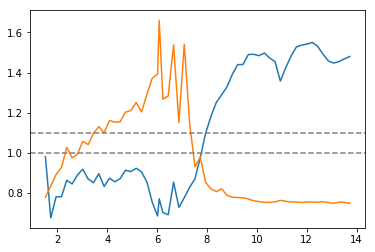

In [32]:
import matplotlib.pyplot as plt

plt.plot(time_M31gs, fdec_M31gs)
plt.plot(time_M31gs, fdisc_M31gs)
plt.axhline(y=1.1,ls='--', color='gray')
plt.axhline(y=1.,ls='--', color='gray')

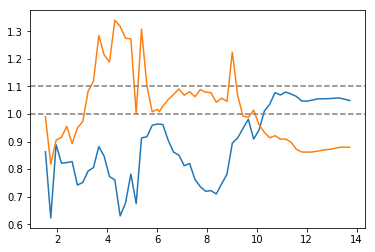

In [30]:
import matplotlib.pyplot as plt

plt.plot(time_MWgs, fdec_MWgs)
plt.plot(time_MWgs, fdisc_MWgs)
plt.axhline(y=1.1,ls='--', color='gray')
plt.axhline(y=1.,ls='--', color='gray')

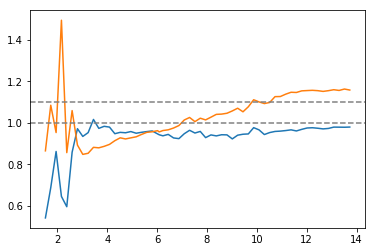

In [29]:
import matplotlib.pyplot as plt

plt.plot(time_M33gs, fdec_M33gs)
plt.plot(time_M33gs, fdisc_M33gs)
plt.axhline(y=1.1,ls='--', color='gray')
plt.axhline(y=1.,ls='--', color='gray')

In [41]:
# path = '/home/omarioni/'
path = '/home/ornela/PYTHON/'

M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime2.dat')
time0_M31gd = M31_gd[:,0][-1]
print time0_M31gd
#------------------------------------------------------------------------------------------
M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_lbarvstime.dat')
time0_M31gs = M31_gs[:,0][-1]
print time0_M31gs

#------------------------------------------------------------------------------------------
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_lbarvstime.dat')
time0_MWgs = MW_gs[:,0][-1]
print time0_MWgs

8.623489
8.159224
10.730151


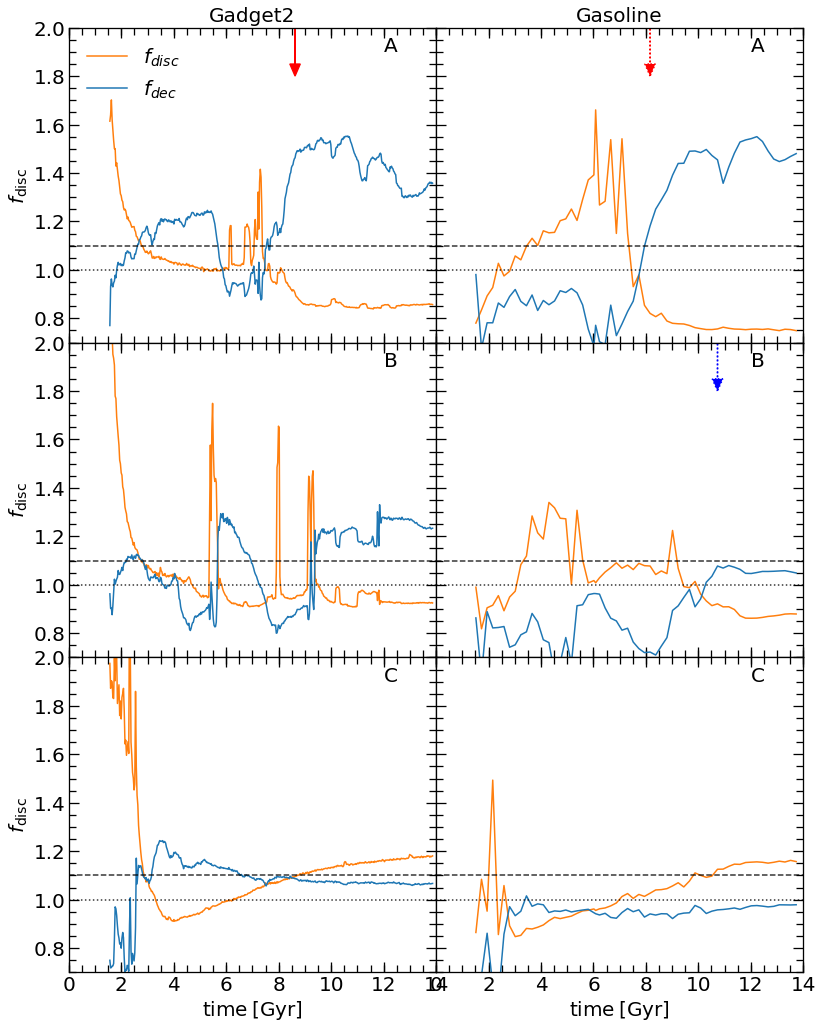

In [43]:
#-----grafico-----------
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 16),sharex=True, sharey=True)#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92,wspace=0,hspace=0)

ax[0,0].plot(time_M31gd, fdisc_M31gd, '-', lw=1.5, color = 'tab:orange', label='$f_{disc}$')
ax[0,0].plot(time_M31gd, fdec_M31gd,'-', lw=1.5, color = 'tab:blue',label='$f_{dec}$')
ax[0,0].set_xlim(0,14)
ax[0,0].set_ylim(0.7,2.)
ax[0,0].set_xticks([0,2,4,6,8,10,12,14])
ax[0,0].set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
# ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[0,0].text(12,1.9,'A',fontsize=20)

ax[0,0].axhline(y=1.0, ls=':',lw=1.5, color='k',alpha=0.8)
ax[0,0].axhline(y=1.1, ls='--',lw=1.5, color='k',alpha=0.8)

ax[0,0].spines['right'].set_linewidth(1.3)
ax[0,0].spines['left'].set_linewidth(1.3)
ax[0,0].spines['top'].set_linewidth(1.3)
ax[0,0].spines['bottom'].set_linewidth(1.3)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=20)
ax[0,0].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax[0,0].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)
ax[0,0].xaxis.set_minor_locator(MultipleLocator(1/2.))
ax[0,0].set_title('Gadget2',fontsize=20)
ax[0,0].legend(fontsize=20, frameon=False, loc=2)
ax[0,0].arrow(x=time0_M31gd,y=2.,dx=0,dy=-0.2,color='r', lw=1.3,
         head_length=0.05,head_width=0.4,length_includes_head=True)


ax[1,0].plot(time_MWgd, fdisc_MWgd, '-', lw=1.5, color = 'tab:orange', label='$f_{disc}$')
ax[1,0].plot(time_MWgd, fdec_MWgd,'-', lw=1.5, color = 'tab:blue',label='$f_{dec}$')
ax[1,0].set_xlim(0,14)
ax[1,0].set_ylim(0.7,2.)
ax[1,0].set_xticks([0,2,4,6,8,10,12,14])
ax[1,0].set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
# ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[1,0].text(12,1.9,'B',fontsize=20)

ax[1,0].axhline(y=1.0, ls=':',lw=1.5, color='k',alpha=0.8)
ax[1,0].axhline(y=1.1, ls='--',lw=1.5, color='k',alpha=0.8)

ax[1,0].spines['right'].set_linewidth(1.3)
ax[1,0].spines['left'].set_linewidth(1.3)
ax[1,0].spines['top'].set_linewidth(1.3)
ax[1,0].spines['bottom'].set_linewidth(1.3)
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=20)
ax[1,0].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax[1,0].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)
ax[1,0].xaxis.set_minor_locator(MultipleLocator(1/2.))


ax[2,0].plot(time_M33gd, fdisc_M33gd, '-', lw=1.5, color = 'tab:orange', label='$f_{disc}$')
ax[2,0].plot(time_M33gd, fdec_M33gd,'-', lw=1.5, color = 'tab:blue',label='$V_{dec}$')
ax[2,0].set_xlim(0,14)
ax[2,0].set_ylim(0.7,2.)
ax[2,0].set_xticks([0,2,4,6,8,10,12,14])
ax[2,0].set_ylabel(r'$f_{\mathrm{disc}}$',fontsize=20)
# ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[2,0].text(12,1.9,'C',fontsize=20)

ax[2,0].axhline(y=1.0, ls=':',lw=1.5, color='k',alpha=0.8)
ax[2,0].axhline(y=1.1, ls='--',lw=1.5, color='k',alpha=0.8)

ax[2,0].spines['right'].set_linewidth(1.3)
ax[2,0].spines['left'].set_linewidth(1.3)
ax[2,0].spines['top'].set_linewidth(1.3)
ax[2,0].spines['bottom'].set_linewidth(1.3)
ax[2,0].minorticks_on()
ax[2,0].tick_params( labelsize=20)
ax[2,0].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax[2,0].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)
ax[2,0].xaxis.set_minor_locator(MultipleLocator(1/2.))
ax[2,0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)


ax[0,1].plot(time_M31gs, fdisc_M31gs, '-', lw=1.5, color = 'tab:orange', label='$f_{disc}$')
ax[0,1].plot(time_M31gs, fdec_M31gs,'-', lw=1.5, color = 'tab:blue',label='$V_{dec}$')
ax[0,1].set_xlim(0,14)
ax[0,1].set_ylim(0.7,2.)
ax[0,1].set_xticks([0,2,4,6,8,10,12,14])
# ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[0,1].text(12,1.9,'A',fontsize=20)

ax[0,1].axhline(y=1.0, ls=':',lw=1.5, color='k',alpha=0.8)
ax[0,1].axhline(y=1.1, ls='--',lw=1.5, color='k',alpha=0.8)

ax[0,1].spines['right'].set_linewidth(1.3)
ax[0,1].spines['left'].set_linewidth(1.3)
ax[0,1].spines['top'].set_linewidth(1.3)
ax[0,1].spines['bottom'].set_linewidth(1.3)
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=20)
ax[0,1].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax[0,1].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)
ax[0,1].xaxis.set_minor_locator(MultipleLocator(1/2.))
ax[0,1].set_title('Gasoline',fontsize=20)
ax[0,1].arrow(x=time0_M31gs,y=2.,dx=0,dy=-0.2,color='r', lw=1.5, ls=':',
         head_length=0.05,head_width=0.4,length_includes_head=True)

ax[1,1].plot(time_MWgs, fdisc_MWgs, '-', lw=1.5, color = 'tab:orange', label='$f_{disc}$')
ax[1,1].plot(time_MWgs, fdec_MWgs,'-', lw=1.5, color = 'tab:blue',label='$f_{dec}$')
ax[1,1].set_xlim(0,14)
ax[1,1].set_ylim(0.7,2.)
ax[1,1].set_xticks([0,2,4,6,8,10,12,14])
# ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[1,1].text(12,1.9,'B',fontsize=20)

ax[1,1].axhline(y=1.0, ls=':',lw=1.5, color='k',alpha=0.8)
ax[1,1].axhline(y=1.1, ls='--',lw=1.5, color='k',alpha=0.8)

ax[1,1].spines['right'].set_linewidth(1.3)
ax[1,1].spines['left'].set_linewidth(1.3)
ax[1,1].spines['top'].set_linewidth(1.3)
ax[1,1].spines['bottom'].set_linewidth(1.3)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=20)
ax[1,1].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax[1,1].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)
ax[1,1].xaxis.set_minor_locator(MultipleLocator(1/2.))
ax[1,1].arrow(x=time0_MWgs,y=2.,dx=0,dy=-0.2,color='b', lw=1.5, ls=':',
         head_length=0.05,head_width=0.4,length_includes_head=True)

ax[2,1].plot(time_M33gs, fdisc_M33gs, '-', lw=1.5, color = 'tab:orange', label='$f_{disc}$')
ax[2,1].plot(time_M33gs, fdec_M33gs,'-', lw=1.5, color = 'tab:blue',label='$f_{dec}$')
ax[2,1].set_xlim(0,14)
ax[2,1].set_ylim(0.7,2.)
ax[2,1].set_xticks([0,2,4,6,8,10,12,14])
# ax[0].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)
ax[2,1].text(12,1.9,'C',fontsize=20)

ax[2,1].axhline(y=1.0, ls=':',lw=1.5, color='k',alpha=0.8)
ax[2,1].axhline(y=1.1, ls='--',lw=1.5, color='k',alpha=0.8)

ax[2,1].spines['right'].set_linewidth(1.3)
ax[2,1].spines['left'].set_linewidth(1.3)
ax[2,1].spines['top'].set_linewidth(1.3)
ax[2,1].spines['bottom'].set_linewidth(1.3)
ax[2,1].minorticks_on()
ax[2,1].tick_params( labelsize=20)
ax[2,1].tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax[2,1].tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)
ax[2,1].xaxis.set_minor_locator(MultipleLocator(1/2.))
ax[2,1].set_xlabel(r'$\mathrm{time\:[Gyr]}$',fontsize=20)

# paths= '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_imagenes/correcciones/fdisk/'
# paths= '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/correcciones/fdisk/'
# fig.savefig(paths+'fdisk_all.png', dpi = 100, xxbox_inches='tight')

plt.show()

In [47]:
import scipy.interpolate as sint

finterp_fdec = sint.interp1d(time_M31gd,fdec_M31gd,fill_value="extrapolate")
finterp_fdisc = sint.interp1d(time_M31gd,fdisc_M31gd,fill_value="extrapolate")

fdec_tbar_M31gd = finterp_fdec(time0_M31gd)
fdisc_tbar_M31gd = finterp_fdisc(time0_M31gd)


finterp_fdec = sint.interp1d(time_MWgd,fdec_MWgd,fill_value="extrapolate")
finterp_fdisc = sint.interp1d(time_MWgd,fdisc_MWgd,fill_value="extrapolate")

fdec_tbar_MWgd = finterp_fdec(8.6)
fdisc_tbar_MWgd = finterp_fdisc(8.6)


finterp_fdec = sint.interp1d(time_M33gd,fdec_M33gd,fill_value="extrapolate")
finterp_fdisc = sint.interp1d(time_M33gd,fdisc_M33gd,fill_value="extrapolate")

fdec_tbar_M33gd = finterp_fdec(8.6)
fdisc_tbar_M33gd = finterp_fdisc(8.6)


finterp_fdec = sint.interp1d(time_M31gs,fdec_M31gs,fill_value="extrapolate")
finterp_fdisc = sint.interp1d(time_M31gs,fdisc_M31gs,fill_value="extrapolate")

fdec_tbar_M31gs = finterp_fdec(time0_M31gs)
fdisc_tbar_M31gs = finterp_fdisc(time0_M31gs)


finterp_fdec = sint.interp1d(time_MWgs,fdec_MWgs,fill_value="extrapolate")
finterp_fdisc = sint.interp1d(time_MWgs,fdisc_MWgs,fill_value="extrapolate")

fdec_tbar_MWgs = finterp_fdec(time0_MWgs)
fdisc_tbar_MWgs = finterp_fdisc(time0_MWgs)


finterp_fdec = sint.interp1d(time_M33gs,fdec_M33gs,fill_value="extrapolate")
finterp_fdisc = sint.interp1d(time_M33gs,fdisc_M33gs,fill_value="extrapolate")

fdec_tbar_M33gs = finterp_fdec(8.6)
fdisc_tbar_M33gs = finterp_fdisc(8.6)


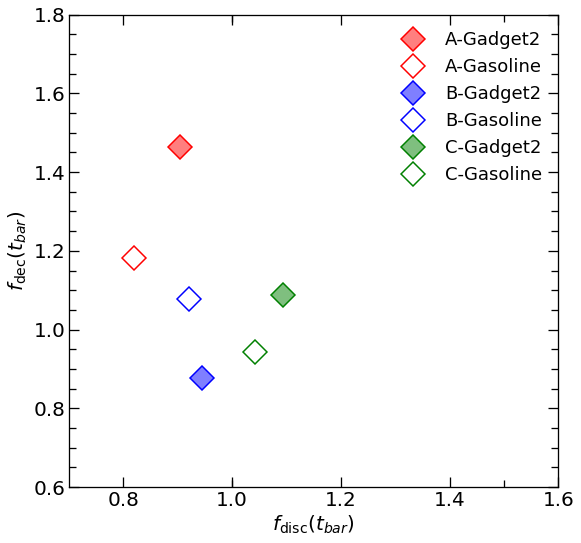

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as color

from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import matplotlib.pyplot as plt
import time_conversion as tiempo
from matplotlib.ticker import AutoMinorLocator

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#, sharex=True, sharey=True)#, sharex=True,
#                        gridspec_kw = {'height_ratios':[2,1,2,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)


ax.plot(fdisc_tbar_M31gd, fdec_tbar_M31gd, 'D', mec='r', mfc=color.to_rgba('r',0.5), ms=17, mew=1.5, label='A-Gadget2')
ax.plot(fdisc_tbar_M31gs, fdec_tbar_M31gs, 'D', mec='r', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5, label='A-Gasoline')
ax.plot(fdisc_tbar_MWgd,  fdec_tbar_MWgd,  'D', mec='b', mfc=color.to_rgba('b',0.5), ms=17, mew=1.5, label='B-Gadget2')
ax.plot(fdisc_tbar_MWgs,  fdec_tbar_MWgs,  'D', mec='b', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5, label='B-Gasoline')
ax.plot(fdisc_tbar_M33gd, fdec_tbar_M33gd, 'D', mec='g', mfc=color.to_rgba('g',0.5), ms=17, mew=1.5, label='C-Gadget2')
ax.plot(fdisc_tbar_M33gs, fdec_tbar_M33gs, 'D', mec='g', mfc=color.to_rgba('w',0.5), ms=17, mew=1.5, label='C-Gasoline')

ax.set_xlim(0.7,1.6)
ax.set_ylim(0.6,1.8)
# ax.set_yscale('log')
# ax.set_xticks([0,2,4,6,8,10,12,14])
# ax.set_yticks(np.arange(1,5,1))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel(r'$f_{\mathrm{disc}}(t_{bar})$',fontsize=20)
ax.set_ylabel(r'$f_{\mathrm{dec}}(t_{bar})$',fontsize=20)

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.minorticks_on()
ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)
ax.xaxis.set_minor_locator(MultipleLocator(1/2.))
# ax.yaxis.set_minor_locator(MultipleLocator(1/5.))
# ax.yaxis.set_minor_formatter(NullFormatter())

ax.legend(fontsize=18,frameon=False, loc=1)

# plt.legend(framealpha=0.5)
# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/Barras.pdf', dpi = 100, xxbox_inches='tight')
fig.savefig('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_imagenes/fdisc_fdec.png', dpi = 100, xxbox_inches='tight',transparent=True)
plt.show()